# Initial analysis of the Kaggle dataset

In [2]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import re
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import openai

* Nodes = tweets
* Edges = similarity between tweets based on meaning (embedding cosine similarity)

In [ ]:
df = pd.read_csv("/Users/ame/02805_climate_conv/data/twitter_sentiment_data.csv",
                 encoding="latin1",
                 on_bad_lines="skip")

df["message"] = df["message"].astype(str)

df = df[df["message"].str.strip().replace("nan", np.nan).notna()]

def clean_text(msg):
    msg = msg.lower()
    msg = re.sub(r"http\S+", "", msg)       # remove URLs
    msg = re.sub(r"rt\s*@\w+:", "", msg)    # remove RT prefix
    msg = re.sub(r"@\w+", "", msg)          # remove mentions
    msg = re.sub(r"#", "", msg)             # remove hashtags
    msg = re.sub(r"[^a-z0-9\s]", " ", msg)  # keep letters/numbers
    msg = re.sub(r"\s+", " ", msg).strip()
    return msg

df["clean_text"] = df["message"].apply(clean_text)

df = df[df["clean_text"].str.len() > 0]

def is_valid_unicode(x):
    try:
        x.encode("utf-8")
        return True
    except:
        return False

df = df[df["clean_text"].apply(is_valid_unicode)]

df = df[df["clean_text"].str.len() <= 8000]

df = df.reset_index(drop=True)

print("Final cleaned dataset:", df.shape)

Final cleaned dataset: (43918, 4)


: 

In [ ]:
# Build nearest-neighbor search over embeddings

EMBEDDINGS_PATH = "/Users/ame/02805_climate_conv/data/tweet_embeddings.npy"

embeddings = np.load(EMBEDDINGS_PATH)

print("Building nearest-neighbor index...")

k = 50  # number of neighbors

nn = NearestNeighbors(n_neighbors=k, metric="cosine")
nn.fit(embeddings)

distances, indices = nn.kneighbors(embeddings)

# Cosine similarity = 1 - cosine distance
similarities = 1 - distances

Building nearest-neighbor index...


: 

In [ ]:
# Build the similarity network with threshold

THRESHOLD = 0.60

G = nx.Graph()

# Add nodes with metadata
for i, row in df.iterrows():
    G.add_node(
        row["tweetid"],
        sentiment=row["sentiment"],
        text=row["clean_text"]
    )

edges_added = 0

print("Building network with similarity threshold =", THRESHOLD)

for i in range(len(df)):
    for j_idx, sim in zip(indices[i], similarities[i]):
        if sim >= THRESHOLD and i != j_idx:
            tid1 = df.loc[i, "tweetid"]
            tid2 = df.loc[j_idx, "tweetid"]

            G.add_edge(tid1, tid2, weight=float(sim))
            edges_added += 1

print("Network created.")
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

# Save the graph to the folder networks

nx.write_gexf(G, "/Users/ame/02805_climate_conv/networks/climate_tweet_network.gexf")
print("Graph saved to networks")

Building network with similarity threshold = 0.6
Network created.
Nodes: 43918
Edges: 819673
Graph saved to networks


: 

In [ ]:
# Print average degree
avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
print("Average degree:", avg_degree)

Average degree: 37.327428389270914


: 

In [ ]:
# Max and min degree
degrees = dict(G.degree()).values()
print("Max degree:", max(degrees))
print("Min degree:", min(degrees))

Max degree: 1590
Min degree: 0


: 

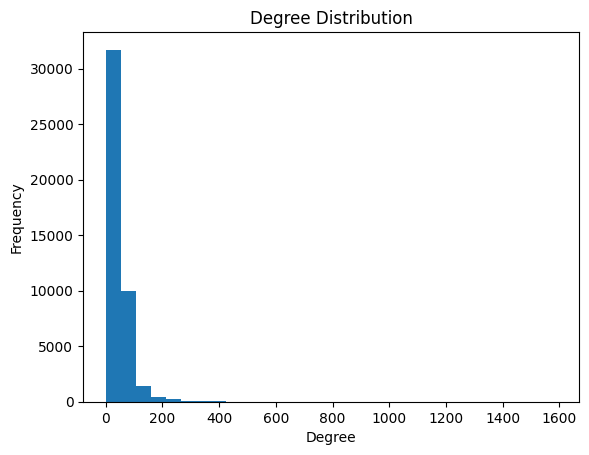

: 

In [ ]:
# Histogram of degree distribution
import matplotlib.pyplot as plt

plt.hist(degrees, bins=30)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Print number of nodes with 0 edges
num_isolated = sum(1 for node in G.nodes() if G.degree(node) == 0)
print("Number of nodes with 0 edges:", num_isolated)

Number of nodes with 0 edges: 3780


: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

deg = dict(G.degree())
node_sizes = [100 + 100*deg[n] for n in G.nodes()]  # tweak for better visualization

pos = nx.forceatlas2_layout(G, max_iter=500, gravity=0.8, scaling_ratio=2.0, seed=123, distributed_action=False, strong_gravity=True)

plt.figure(figsize=(10, 10))
nx.draw_networkx_edges(G, pos, width=0.3, alpha=0.3)
nodes = nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    cmap="cividis",               # sequential colormap
)
plt.colorbar(nodes, label="Number of retweets per user", ax=plt.gca(), fraction=0.03)
plt.axis('off')
plt.title("Users (directed view)")
plt.show()

NameError: name 'G' is not defined

: 